## DC2 Classification Accuracy

In [1]:
import torch
from os import environ
from pathlib import Path
from einops import rearrange
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from hydra.utils import instantiate

from pytorch_lightning.utilities import move_data_to_device

from bliss.catalog import FullCatalog
from bliss.surveys.dc2 import DC2, unsqueeze_tile_dict
from case_studies.dc2_cataloging.utils.load_lsst import get_lsst_full_cat
from case_studies.dc2_cataloging.utils.safe_metric_collection import SafeMetricCollection as MetricCollection

output_dir = Path("./DC2_classification_accuracy_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../output/DC2_cataloging_exp/exp/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
dc2: DC2 = instantiate(notebook_cfg.surveys.dc2)
test_sample = dc2.get_plotting_sample(0)
cur_image_wcs = test_sample["wcs"]
cur_image_true_full_catalog = test_sample["full_catalog"]
cur_image_match_id = test_sample["match_id"]
image_lim = test_sample["image"].shape[1]
r_band_min_flux = notebook_cfg.encoder.min_flux_for_metrics

In [4]:
lsst_full_cat = get_lsst_full_cat(lsst_root_dir=lsst_root_dir,
                                  cur_image_wcs=cur_image_wcs,
                                  image_lim=image_lim,
                                  r_band_min_flux=r_band_min_flux,
                                  device=device)

In [5]:
bliss_encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder.eval();

In [6]:
batch = {
    "tile_catalog": unsqueeze_tile_dict(test_sample["tile_catalog"]),
    "images": rearrange(test_sample["image"], "h w nw -> 1 h w nw"),
    "background": rearrange(test_sample["background"], "h w nw -> 1 h w nw"),
    "psf_params": rearrange(test_sample["psf_params"], "h w -> 1 h w")
}

batch = move_data_to_device(batch, device=device)

bliss_output_path = output_dir / "bliss_output.pkl"

if not bliss_output_path.exists():
    bliss_out_dict = bliss_encoder.predict_step(batch, None)

    with open(bliss_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(bliss_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(bliss_output_path, "rb") as inputp:
        bliss_out_dict = pickle.load(inputp)

In [7]:
bliss_full_cat: FullCatalog = bliss_out_dict["mode_cat"].to_full_catalog()

In [8]:
matcher = instantiate(notebook_cfg.encoder.matcher)
bliss_metrics = instantiate(notebook_cfg.encoder.metrics)
bliss_metrics = MetricCollection({
    "source_type_accuracy": bliss_metrics["source_type_accuracy"],
    "source_type_accuracy_star": bliss_metrics["source_type_accuracy_star"],
    "source_type_accuracy_galaxy": bliss_metrics["source_type_accuracy_galaxy"],
}).to(device=device)
lsst_metrics = bliss_metrics.clone()

bliss_results = {}
lsst_results = {}

classification_result_path = output_dir / "classification_result.pkl"
if not classification_result_path.exists():
    bliss_matching = matcher.match_catalogs(cur_image_true_full_catalog, bliss_full_cat)
    bliss_metrics.update(cur_image_true_full_catalog, bliss_full_cat, bliss_matching)

    lsst_matching = matcher.match_catalogs(cur_image_true_full_catalog, lsst_full_cat)
    lsst_metrics.update(cur_image_true_full_catalog, lsst_full_cat, lsst_matching)

    for k, v in bliss_metrics.items():
        resutls = v.get_results_on_per_flux_bin()
        for k_results, v_results in resutls.items():
            bliss_results[k_results] = v_results.cpu()

    for k, v in lsst_metrics.items():
        resutls = v.get_results_on_per_flux_bin()
        for k_results, v_results in resutls.items():
            lsst_results[k_results] = v_results.cpu()

        with open(classification_result_path, "wb") as classification_result_file:
                pickle.dump({
                    "bliss_results": bliss_results,
                    "lsst_results": lsst_results,
                }, classification_result_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(classification_result_path, "rb") as classification_result_file:
          classification_result = pickle.load(classification_result_file)
    bliss_results = classification_result["bliss_results"]
    lsst_results = classification_result["lsst_results"]

In [9]:
def plot(classification_acc_1,
        classification_acc_2,
        flux_bin_cutoffs,
        postfix_str, 
        model_name_1, 
        model_name_2):
    xlabels = (
        ["[100, " + str(flux_bin_cutoffs[0]) + "]"]
        + [f"[{flux_bin_cutoffs[i]}, {flux_bin_cutoffs[i + 1]}]" for i in range(len(flux_bin_cutoffs) - 1)]
        + ["> " + str(flux_bin_cutoffs[-1])]
    )

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(
        1, 1, figsize=(10, 10), sharey=True
    )
    c1, c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0:2]
    graph_tag = f"({postfix_str[1:]})" if postfix_str else ""
    
    ax.plot(
        range(len(xlabels)),
        classification_acc_1.tolist(),
        color=c1,
        label=f"{model_name_1} Classification Acc {graph_tag}",
    )
    ax.plot(
        range(len(xlabels)),
        classification_acc_2.tolist(),
        color=c2,
        label=f"{model_name_2} Classification Acc {graph_tag}",
    )
    ax.set_xlabel("Flux")
    ax.set_xticks(range(len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=45)
    ax.legend()
  
    plt.tight_layout()
    plt.show()

    return fig, ax

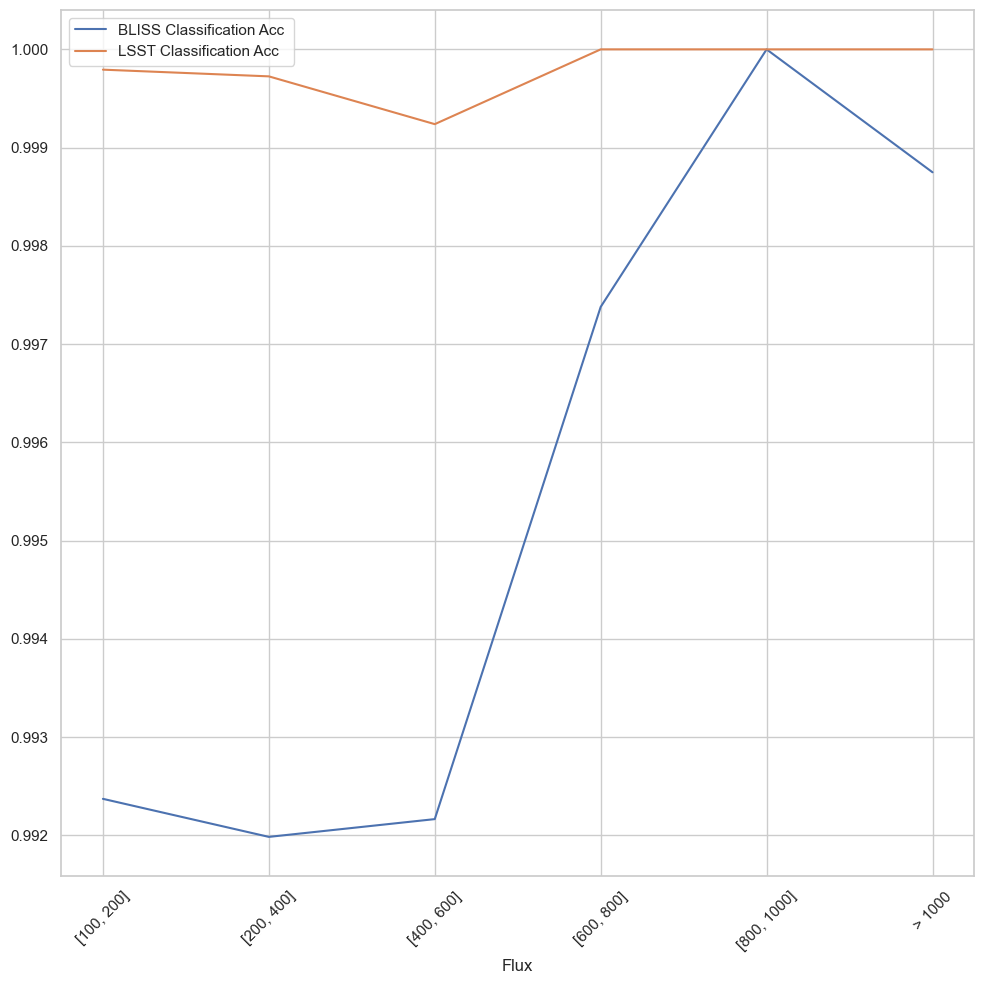

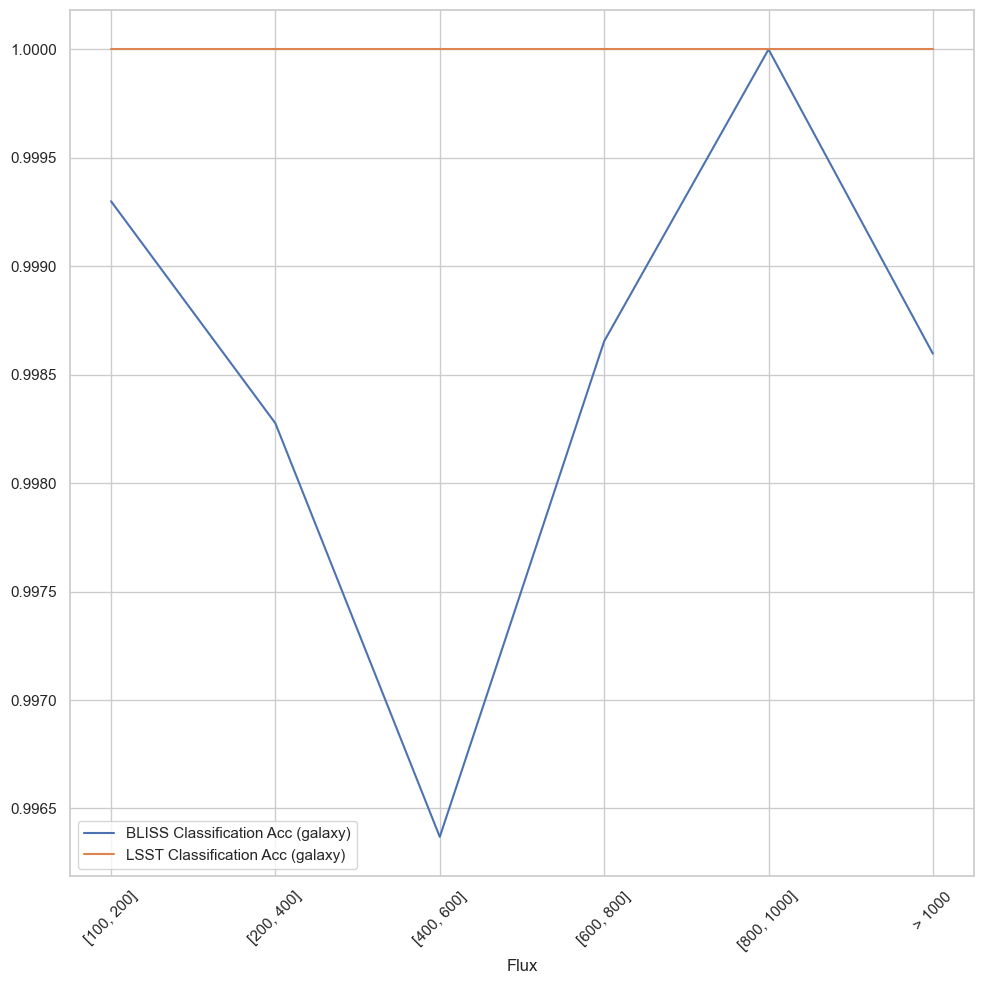

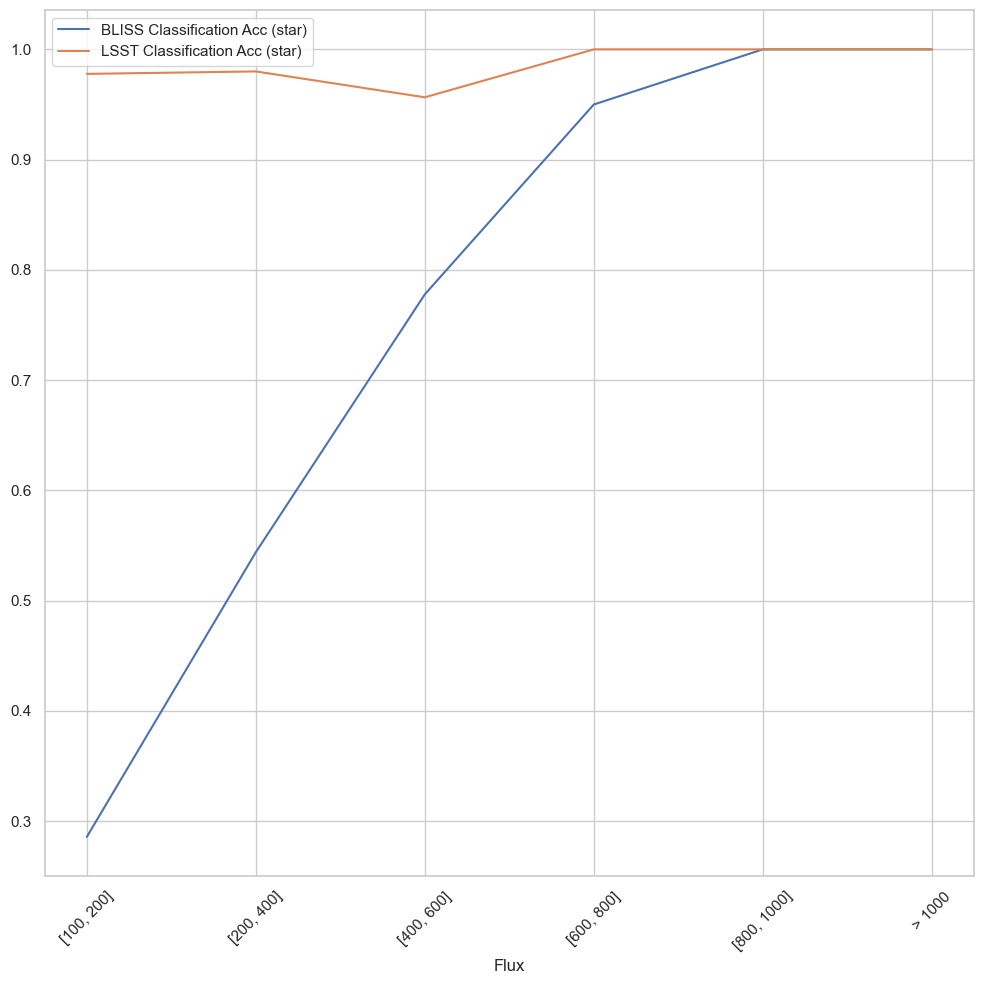

In [10]:
for k, v in bliss_metrics.items():
    flux_bin_cutoffs = v.flux_bin_cutoffs
    postfix_str = v.postfix_str
    fig, ax = plot(bliss_results[f"classification_acc{postfix_str}"],
                    lsst_results[f"classification_acc{postfix_str}"],
                    flux_bin_cutoffs=flux_bin_cutoffs,
                    postfix_str=postfix_str,
                    model_name_1="BLISS",
                    model_name_2="LSST")
    
    fig.show()